In [2]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipynb.fs.full.project_functions as prf

In [3]:
engine = create_engine('postgresql:///opportunity_youth') # since database is owned by me, no other credentials are needed

In [4]:
hs_diploma = """
SELECT pwgtp, agep, schl
FROM pums_2017
WHERE (puma BETWEEN '11610' AND '11615')
    AND (agep BETWEEN 16 AND 24)
    AND (esr  = '3' OR esr = '6')
    AND (schl = '16' OR schl = '17')
    AND sch = '1'
;"""


In [5]:
no_degree = """
SELECT pwgtp, agep, schl
FROM pums_2017
WHERE (puma BETWEEN '11610' AND '11615')
    AND (agep BETWEEN 16 AND 24)
    AND (esr  = '3' OR esr = '6')
    AND (schl <= '15')
    AND sch = '1'
;"""


In [6]:
some_college = """
SELECT pwgtp, agep, schl
FROM pums_2017
WHERE (puma BETWEEN '11610' AND '11615')
    AND (agep BETWEEN 16 AND 24)
    AND (esr  = '3' OR esr = '6')
    AND (schl = '18' OR schl = '19')
    AND sch = '1'
;
"""

In [7]:
college_deg = """
SELECT pwgtp, agep, schl
FROM pums_2017
WHERE (puma BETWEEN '11610' AND '11615')
    AND (agep BETWEEN 16 AND 24)
    AND (esr  = '3' OR esr = '6')
    AND (schl BETWEEN '20' AND '24')
    AND sch = '1'
;
    """

In [8]:
total_oy = """
SELECT pwgtp, agep, schl
FROM pums_2017
WHERE (puma BETWEEN '11610' AND '11615')
    AND (agep BETWEEN 16 AND 24)
    AND (esr  = '3' OR esr = '6')
    AND sch = '1'
;
    """

In [9]:
df_total_oy = pd.read_sql(sql = total_oy, con = engine) #data frame for individuals with highschool degree or GED
df_hs_ged = pd.read_sql(sql = hs_diploma, con = engine) #data frame for individuals with highschool degree or GED
df_no_degree = pd.read_sql(sql = no_degree, con = engine) #data frame for individuals with no degree
df_some_college = pd.read_sql(sql = some_college, con = engine) #data frame for individuals with some college experience
df_col_deg = pd.read_sql(sql = college_deg, con = engine) #data frame for individuals with an AA degree or higher

In [10]:
df_col_deg['pwgtp'].sum()

506.0

In [11]:
df_total_oy['schl'].value_counts()

16    146
17     35
19     30
13     28
14     28
15     28
18     26
12     17
01     14
21     12
11     10
20      8
06      2
10      2
08      2
22      1
09      1
05      1
Name: schl, dtype: int64

In [12]:
df_hs_ged['schl'].value_counts()

16    146
17     35
Name: schl, dtype: int64

In [13]:
df_no_degree['schl'].value_counts()

15    28
13    28
14    28
12    17
01    14
11    10
10     2
06     2
08     2
09     1
05     1
Name: schl, dtype: int64

### functions used for the project

In [35]:
def get_average(data, col_name, age1 = 16, age2 = 24):
    try: 
        filtered_data = data[(data.agep >= age1) & (data.agep <= age2)]
        filtered_data['weighted_sum'] = filtered_data[col_name]*filtered_data['pwgtp']
        sum_of_weighted_data = filtered_data['weighted_sum'].sum()
        sum_of_weights = filtered_data['pwgtp'].sum()
        return sum_of_weighted_data/sum_of_weights
    except:
        print("operation could not be completed")


def weight_sum(df):
    weighted_sum = df['pwgtp'].sum()
    return weighted_sum
                      

def trisect_ages(df):
    df_16_18 = df[(df.agep>=16) & (df.agep <= 18)]
    value_16_18 = weight_sum(df_16_18)
    
    df_19_21 = df[(df.agep>=19) & (df.agep <= 21)]
    value_19_21 = weight_sum(df_19_21)
    
    df_22_24 = df[(df.agep>=22) & (df.agep <= 24)]
    value_22_24 = weight_sum(df_22_24)
    
    value_total = weight_sum(df)
    
    value_array = np.array([value_16_18, value_19_21, value_22_24, value_total])
    return value_array

def form_another_2d_array(df_list):
    new_list = np.zeros(len(df_list)+1)
    final_table = np.array([trisect_ages(x_df) for x_df in df_list])
    
#     for x in range(len(df_list)+1):
#         for y in range(len(df_list[0])+1)
#         element = df_table[0][x]-(df_table[1][x]+df_table[2][x]+df_table[3][x]+df_table[4][x])
#         print(element)
#         new_list[x] = element
#     final_table = np.append(df_table, [new_list], axis = 0)
    
    return final_table
    

def create_df(array_entry, columns_entry, index_entry):
    df = pd.DataFrame(array_entry, columns = columns_entry, index = index_entry)
    return df

def add_percentages(df):
    for col in df.columns:
        if 'total' in col:
            df["{} percentage".format(col[:5])] = round(df[col]/df.loc['Total Population', col]*100)
            
def add_percentages_total(df):
    for col in df.columns:
        if 'total' in col:
            df["{} percentage".format(col[:5])] = round(df[col]/df.loc['Total Population', '16-24 total']*100)
            
def get_plot_info(df_new, df_original, row):
    labels= ['16-18 percentage', '19-21 percentage', '22-24 percentage', 'total percentage']
    x = [] # values of the first bar graph
    y = [] # values of the second bar graph
    z = np.arange(len(labels)) # label location
    width = .35 # width of the bars
    for col in df_new.columns:
        if ('percentage' in col):
            x.append(df_new.loc[row,col])
    for col in df_original.columns:
        if ('percentage' in col):
            y.append(df_original.loc[row,col])
    return x, y, z, width


    

### creating the database

In [15]:
tri_sected1 = trisect_ages(df_col_deg)
tri_sected2 = trisect_ages(df_no_degree)
tri_sected5 = trisect_ages(df_total_oy)
tri_sected5


array([ 1815.,  3902.,  4897., 10614.])

In [16]:
second_array = form_another_2d_array([df_total_oy, df_no_degree, df_hs_ged, df_some_college, df_col_deg])
second_array

array([[ 1815.,  3902.,  4897., 10614.],
       [  916.,  1112.,  1349.,  3377.],
       [  781.,  2176.,  2135.,  5092.],
       [  118.,   521.,  1000.,  1639.],
       [    0.,    93.,   413.,   506.]])

In [17]:
column_names = ['16-18 total', '19-21 total', '22-24 total', '16-24 total']

In [18]:
index_names = ['Total Population', 'No HS Degree or GED', 'High School Degree/GED','Some College', 'AA or higher']

In [19]:
second_df = create_df(second_array, column_names, index_names)

In [20]:
second_df

,16-18 total,19-21 total,22-24 total,16-24 total
Total Population,1815.0,3902.0,4897.0,10614.0
No HS Degree or GED,916.0,1112.0,1349.0,3377.0
High School Degree/GED,781.0,2176.0,2135.0,5092.0
Some College,118.0,521.0,1000.0,1639.0
AA or higher,0.0,93.0,413.0,506.0


In [21]:
reorganized_list = ['16-18 percentage','16-18 total', '19-21 percentage', '19-21 total', '22-24 percentage', '22-24 total', '16-24 percentage', '16-24 total', ]

In [22]:
second_df = second_df.reindex(columns = reorganized_list)
second_df



,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,NaN,1815.0,NaN,3902.0,NaN,4897.0,NaN,10614.0
No HS Degree or GED,NaN,916.0,NaN,1112.0,NaN,1349.0,NaN,3377.0
High School Degree/GED,NaN,781.0,NaN,2176.0,NaN,2135.0,NaN,5092.0
Some College,NaN,118.0,NaN,521.0,NaN,1000.0,NaN,1639.0
AA or higher,NaN,0.0,NaN,93.0,NaN,413.0,NaN,506.0


In [23]:
add_percentages_total(second_df)

In [24]:
second_df

,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,100.0,1815.0,100.0,3902.0,100.0,4897.0,100.0,10614.0
No HS Degree or GED,50.0,916.0,28.0,1112.0,28.0,1349.0,32.0,3377.0
High School Degree/GED,43.0,781.0,56.0,2176.0,44.0,2135.0,48.0,5092.0
Some College,7.0,118.0,13.0,521.0,20.0,1000.0,15.0,1639.0
AA or higher,0.0,0.0,2.0,93.0,8.0,413.0,5.0,506.0


In [25]:
original2_data = np.array([[2805,7284,8728,18817],[1610, 2048, 1981, 5639], [985, 3349, 3067, 7401],[179, 1666, 1763, 3608], [31, 221, 1917, 2169]])

In [26]:
original2_data

array([[ 2805,  7284,  8728, 18817],
       [ 1610,  2048,  1981,  5639],
       [  985,  3349,  3067,  7401],
       [  179,  1666,  1763,  3608],
       [   31,   221,  1917,  2169]])

In [27]:
original2_df = create_df(original2_data, column_names, index_names)

In [28]:
original2_df

,16-18 total,19-21 total,22-24 total,16-24 total
Total Population,2805,7284,8728,18817
No HS Degree or GED,1610,2048,1981,5639
High School Degree/GED,985,3349,3067,7401
Some College,179,1666,1763,3608
AA or higher,31,221,1917,2169


In [29]:
original2_df = original2_df.reindex(columns = reorganized_list)

In [30]:
original2_df

,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,NaN,2805,NaN,7284,NaN,8728,NaN,18817
No HS Degree or GED,NaN,1610,NaN,2048,NaN,1981,NaN,5639
High School Degree/GED,NaN,985,NaN,3349,NaN,3067,NaN,7401
Some College,NaN,179,NaN,1666,NaN,1763,NaN,3608
AA or higher,NaN,31,NaN,221,NaN,1917,NaN,2169


In [36]:
add_percentages_total(original2_df)

In [32]:
original2_df

,16-18 percentage,16-18 total,19-21 percentage,19-21 total,22-24 percentage,22-24 total,16-24 percentage,16-24 total
Total Population,100.0,2805,100.0,7284,100.0,8728,100.0,18817
No HS Degree or GED,57.0,1610,28.0,2048,23.0,1981,30.0,5639
High School Degree/GED,35.0,985,46.0,3349,35.0,3067,39.0,7401
Some College,6.0,179,23.0,1666,20.0,1763,19.0,3608
AA or higher,1.0,31,3.0,221,22.0,1917,12.0,2169


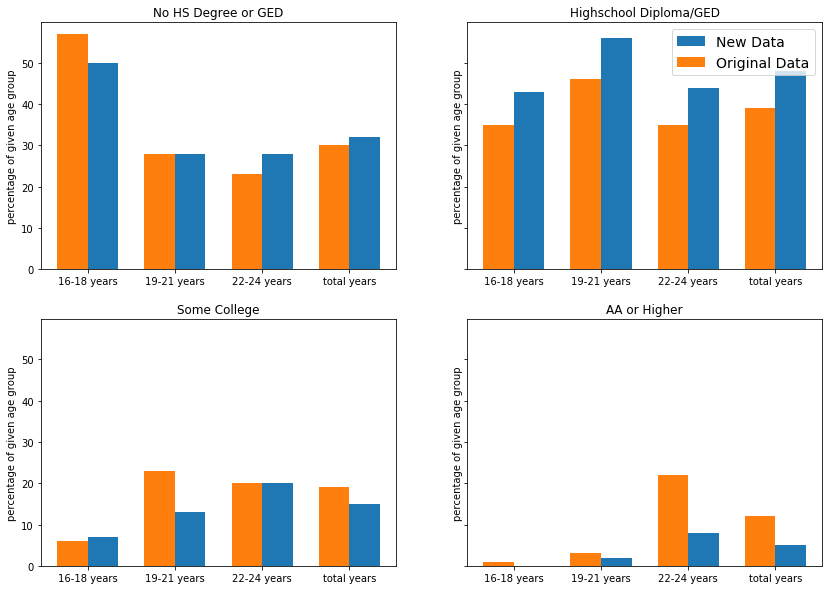

In [34]:
x, y, z, w = get_plot_info(second_df, original2_df, 'No HS Degree or GED')
x1, y1, z1, w1 = get_plot_info(second_df, original2_df, 'High School Degree/GED')
x2, y2, z2, w2 = get_plot_info(second_df, original2_df, 'Some College')
x3, y3, z3, w3 = get_plot_info(second_df, original2_df, 'AA or higher')

labels = ['16-18 years', '19-21 years', '22-24 years', 'total years']

fig, ax = plt.subplots(2,2, figsize = (14,10), sharey = True)

rect1a = ax[0][0].bar(z + w/2, x,  w, label='New Data')
rect1b = ax[0][0].bar(z - w/2, y,  w, label='Original Data')

rect2a = ax[0][1].bar(z1 + w1/2, x1,  w1, label='New Data')
rect2b = ax[0][1].bar(z1 - w1/2, y1,  w1, label='Original Data')

rect3a = ax[1][0].bar(z2 + w2/2, x2,  w2, label='New Data')
rect3b = ax[1][0].bar(z2 - w2/2, y2,  w2, label='Original Data')

rect4a = ax[1][1].bar(z3 + w3/2, x3,  w3, label='New Data')
rect4b = ax[1][1].bar(z3 - w3/2, y3,  w3, label='Original Data')

ax[0][0].title.set_text('No HS Degree or GED')
ax[0][1].title.set_text('Highschool Diploma/GED')
ax[1][0].title.set_text('Some College')
ax[1][1].title.set_text('AA or Higher')

for x in range(2):
    for y in range (2):
        ax[x][y].set_xticks(z)
        ax[x][y].set_xticklabels(labels)
        ax[x][y].set_ylabel('percentage of given age group')

ax[0][1].legend(prop= {'size':14})

